In [ ]:
!pip install gradio

In [ ]:
# Importando bibliotecas
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import gradio as gr

In [ ]:
# Carregar os dados
data = pd.read_csv("Fluxo Escolar 2013_2023.csv")

# Filtrar os dados necessários
data = data[['ANO_LETIVO', 'MESORREGIAO', 'APR_3', 'REP_3', 'ABA_3']]

In [ ]:
# Converter a coluna MESORREGIAO para valores numéricos usando LabelEncoder
label_encoder = LabelEncoder()
data['MESORREGIAO_ENCODED'] = label_encoder.fit_transform(data['MESORREGIAO'])


Distribuição de categorias de evasão escolar:
ABA_CATEGORIA
Baixa    3796
Alta     1961
Média    1328
Name: count, dtype: int64


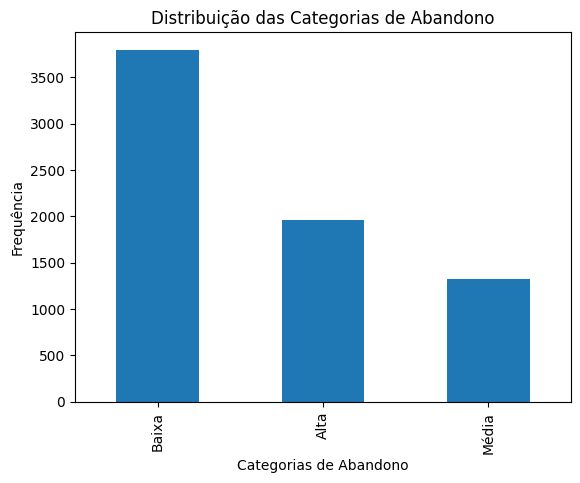

In [ ]:
# Converter ABA_3 em categorias altas, médias e baixas
bins = [0, 1, 3, float('inf')]
labels = ['Baixa', 'Média', 'Alta']
data['ABA_CATEGORIA'] = pd.cut(data['ABA_3'], bins=bins, labels=labels, right=False)

data['ABA_CATEGORIA'] = data['ABA_CATEGORIA'].fillna('Média')

# Exibir a distribuição de categorias
print("\nDistribuição de categorias de evasão escolar:")
print(data['ABA_CATEGORIA'].value_counts())

# Verificar a distribuição das classes
data['ABA_CATEGORIA'].value_counts().plot(kind='bar', title='Distribuição das Categorias de Abandono')
plt.xlabel('Categorias de Abandono')
plt.ylabel('Frequência')
plt.show()


In [ ]:
# Preparar os dados de entrada (X) e a saída (y)
X = data[['MESORREGIAO_ENCODED', 'APR_3', 'REP_3', 'ANO_LETIVO']]
y = data['ABA_CATEGORIA']

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicar o SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Treinar o modelo com os dados balanceados
model = DecisionTreeClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Fazer predições no conjunto de teste
y_pred = model.predict(X_test)


Distribuição de categorias de evasão escolar:
ABA_CATEGORIA
Baixa    2689
Média    2689
Alta     2689
Name: count, dtype: int64


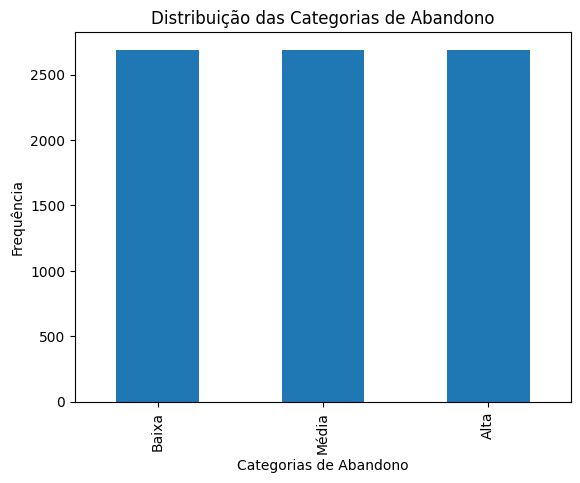

In [ ]:
# Exibir a distribuição de categorias
print("\nDistribuição de categorias de evasão escolar:")
print(y_resampled.value_counts())

# Verificar a distribuição das classes
y_resampled.value_counts().plot(kind='bar', title='Distribuição das Categorias de Abandono')
plt.xlabel('Categorias de Abandono')
plt.ylabel('Frequência')
plt.show()

In [ ]:
# Calcular a acurácia
acuracia = accuracy_score(y_test, y_pred)

# Calcular precision, recall e f1-score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Função para exibir as métricas do modelo
def obter_metricas():
    return (f"Acurácia: {acuracia:.2f}\n"
            f"Precisão (Precision): {precision:.2f}\n"
            f"Revocação (Recall): {recall:.2f}\n"
            f"F1-Score: {f1:.2f}")

In [ ]:
# Função para prever a categoria (Baixa, Média ou Alta)
def prever_abandono(ano, mesorregiao):
    try:
        # Codificar a mesorregião fornecida
        mesorregiao_encoded = label_encoder.transform([mesorregiao])[0]
    except ValueError:
        return f"Mesorregião '{mesorregiao}' não encontrada no dataset!"

    filtro = (data['ANO_LETIVO'] == ano) & (data['MESORREGIAO_ENCODED'] == mesorregiao_encoded)
    dados_filtrados = data[filtro]

    # Verificar se existem dados correspondentes
    if dados_filtrados.empty:
        return f"Nenhum dado encontrado para o ano {ano} e a mesorregião '{mesorregiao}'!"

    # Obter os valores de APR_3 e REP_3 do banco de dados
    apr_3 = dados_filtrados['APR_3'].iloc[0]
    rep_3 = dados_filtrados['REP_3'].iloc[0]

    # Criar os dados de entrada para a previsão
    input_data = pd.DataFrame({
        'MESORREGIAO_ENCODED': [mesorregiao_encoded],
        'APR_3': [apr_3],
        'REP_3': [rep_3],
        'ANO_LETIVO': [ano]
    })

    # Fazer a previsão
    prediction = model.predict(input_data)[0]
    return f"A categoria de abandono escolar prevista é: {prediction}"


In [ ]:
# Criar a interface com Gradio
with gr.Blocks() as demo:
    gr.Markdown("# Previsão de Evasão Escolar")
    gr.Markdown("Insira o ano letivo e a mesorregião para prever a categoria de abandono escolar (Baixa, Média ou Alta).")

    ano = gr.Number(label="Ano letivo (2013-2024)", value=2023)
    mesorregiao = gr.Dropdown(
        label="Mesorregião",
        choices=data['MESORREGIAO'].unique().tolist()
    )
    output = gr.Textbox(label="Resultado da Previsão")
    metricas_output = gr.Textbox(label="Métricas do Modelo")

    btn_prever = gr.Button("Prever")
    btn_prever.click(prever_abandono, inputs=[ano, mesorregiao], outputs=output)

    btn_metricas = gr.Button("Exibir Métricas")
    btn_metricas.click(obter_metricas, inputs=[], outputs=metricas_output)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ba55b048601a0c3d2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
